# Structural Sensitivity of S&P 500 Drawdowns to NVDA Exposure Assumptions

## Executive Summary

This study evaluates the structural sensitivity of S&P 500 (SPX) drawdown behavior to assumed NVDA index exposure within a simplified linear return decomposition framework. Rather than attempting causal attribution, the analysis isolates how varying structural exposure assumptions affect simulated stress outcomes.

Key findings:

* **Rolling beta analysis**: NVDA has frequently exhibited a systemic-level statistical relationship with SPX returns, with elevated rolling beta regimes observed during early 2020 and again throughout 2025. These periods suggest episodes in which NVDA’s return behavior was unusually influential relative to the broader index.

* **Shock simulations**: Under one-day NVDA shock scenarios, maximum drawdown in SPX scales predictably with both the assumed NVDA weight and the magnitude of the shock. Recovery time remains short in most simulated cases unless both the weight and shock magnitude are extreme.

* **Sensitivity to exposure assumptions**: Heatmap analysis demonstrates that stress outcomes are highly sensitive to structural exposure assumptions. Even under a stylized linear model, larger assumed NVDA weights materially increase simulated index drawdowns.

This framework is intentionally simplified; it assumes constant exposure weights, no endogenous feedback effects, and no multi-day volatility dynamics. As such, results should be interpreted as sensitivity analysis under a stylized structural model rather than as forecasts or causal claims.

Future extensions could incorporate time-varying index weights, multi-day shock paths, and more realistic feedback mechanisms to better approximate market dynamics.

In [1]:
import sys
from pathlib import Path

# add project root to Python path (so that the notebook can see src)
project_root = Path.cwd().parent
sys.path.append(str(project_root))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# standardizing figure sizes for plots
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
})

from src.nvda_spx.data import download_prices
from src.nvda_spx.ex_nvda import ex_nvda_return
from src.nvda_spx.scenarios import shocked_spx_returns
from src.nvda_spx.metrics import weight_sensitivity_table
from src.nvda_spx.plotting import (
    plot_rolling_beta_windows,
    plot_sensitivity_heatmap,
    plot_cumulative,
)

# Consistent plot sizing for the report
plt.rcParams["figure.figsize"] = (10, 6)

START = "2018-01-01"
END = None

## Motivation and Framing

Recent market commentary has highlighted the increasing concentration of major U.S. equity indices in a small number of large-cap technology firms, particularly during the period of rapid AI-driven valuation expansion. NVIDIA (NVDA), as a leading semiconductor firm closely associated with AI infrastructure growth, has been one of the most prominent contributors to index-level performance in recent years.

While public discussion often focuses on whether such firms are “driving the market,” that framing can conflate statistical co-movement with structural exposure. This study adopts a more mechanical perspective: rather than attempting to estimate causal influence, it evaluates how sensitive index-level stress outcomes are to assumptions about a dominant constituent’s exposure weight.

Specifically, the analysis asks:

> Under a simplified linear decomposition of SPX returns, how do simulated drawdowns respond to different assumptions about NVDA’s structural index weight?

NVDA is therefore used as an illustrative case study within a broader methodological question: how does index-level risk behavior depend on structural exposure assumptions in a cap-weighted framework?

The objective is not to determine whether NVDA “causes” index movements, but to examine how varying exposure assumptions alter stress-test outcomes under stylized conditions.

## Data and Preprocessing

Daily adjusted closing price data for NVDA and the S&P 500 index (SPX) were obtained via the `yfinance` API. Adjusted prices were used to account for corporate actions such as stock splits and dividends, ensuring consistency in return calculations.

Returns were computed as **daily simple returns**, defined as:

$$ r_t = \frac{P_t - P_{t-1}}{P_{t-1}}. $$

Daily simple returns were chosen for interpretability and because, at daily frequency, simple and log returns are numerically similar. Log returns may offer desirable aggregation properties over longer horizons, but for the short-horizon stress simulations conducted here, simple returns provide a sufficiently accurate and transparent representation.

Missing observations were not forward-filled; instead, any dates with incomplete data were excluded to avoid introducing artificial smoothing or bias into the return series.

All subsequent analysis is performed on aligned daily return series for NVDA and SPX over the selected sample period (since the start of 2018), which covers both pre- and post-AI expansion phases as well as the early COVID-19 period.

In [3]:
prices = download_prices(
    spx_ticker="^GSPC",
    nvda_ticker="NVDA",
    start_date=START,
    end_date=END,
)

rets = prices.pct_change().dropna()

In [4]:
start_date = rets.index.min().date()
end_date = rets.index.max().date()
n_obs = len(rets)

print(
    f"The sample spans from {start_date:%B %d, %Y} "
    f"to {end_date:%B %d, %Y} "
    f"and contains {n_obs:,} daily observations."
)

The sample spans from January 03, 2018 to February 25, 2026 and contains 2,047 daily observations.


## Linear Decomposition Framework

To evaluate structural sensitivity, SPX returns are decomposed using a simplified linear exposure identity:

$$ r_{SPX,t} = w r_{NVDA,t} + (1-w)r_{exNVDA,t},$$

where:

* $r_{SPX,t}$ is the daily SPX return,
* $r_{NVDA,t}$ is the daily NVDA return,
* $r_{exNVDA,t}$ represents the return of the index excluding NVDA, and
* $w \in [0,1)$ is an assumed structural weight representing NVDA’s share of index exposure.

Solving algebraically for the residual component yields:

$$ r_{exNVDA,t} = \frac{r_{SPX,t} - w r_{NVDA,t}}{1-w}. $$

This decomposition is mechanical and does not imply causality. The parameter $w$ should not be interpreted as a regression coefficient, beta estimate, or correlation measure. Instead, it represents a structural exposure assumption: the fraction of index return mechanically attributed to NVDA within a cap-weighted framework.

Varying $w$ therefore does not change the observed data, but alters the implied counterfactual index return stream excluding NVDA. Sensitivity analysis over $w$ evaluates how stress outcomes depend on these structural exposure assumptions.

In this study, $w$ is treated as an uncertain parameter and varied over a plausible range to assess robustness of simulated drawdown behavior.

## Rolling Beta Analysis

To evaluate the statistical relationship between NVDA and SPX returns over time, rolling beta estimates were computed using ordinary least squares (OLS) regressions within fixed-length windows.

Formally, for each rolling window of length $t$, the beta estimate is:

$$ \beta_t = \frac{\mathrm{Cov}(r_{NVDA}, r_{SPX})}{\mathrm{Var}(r_{NVDA})}, $$

which corresponds to the slope coefficient from the regression:

$$ r_{SPX} = \alpha + \beta r_{NVDA} + \varepsilon. $$

Rolling windows of 60, 120, and 252 trading days were examined to assess robustness across short-, medium-, and longer-term horizons.

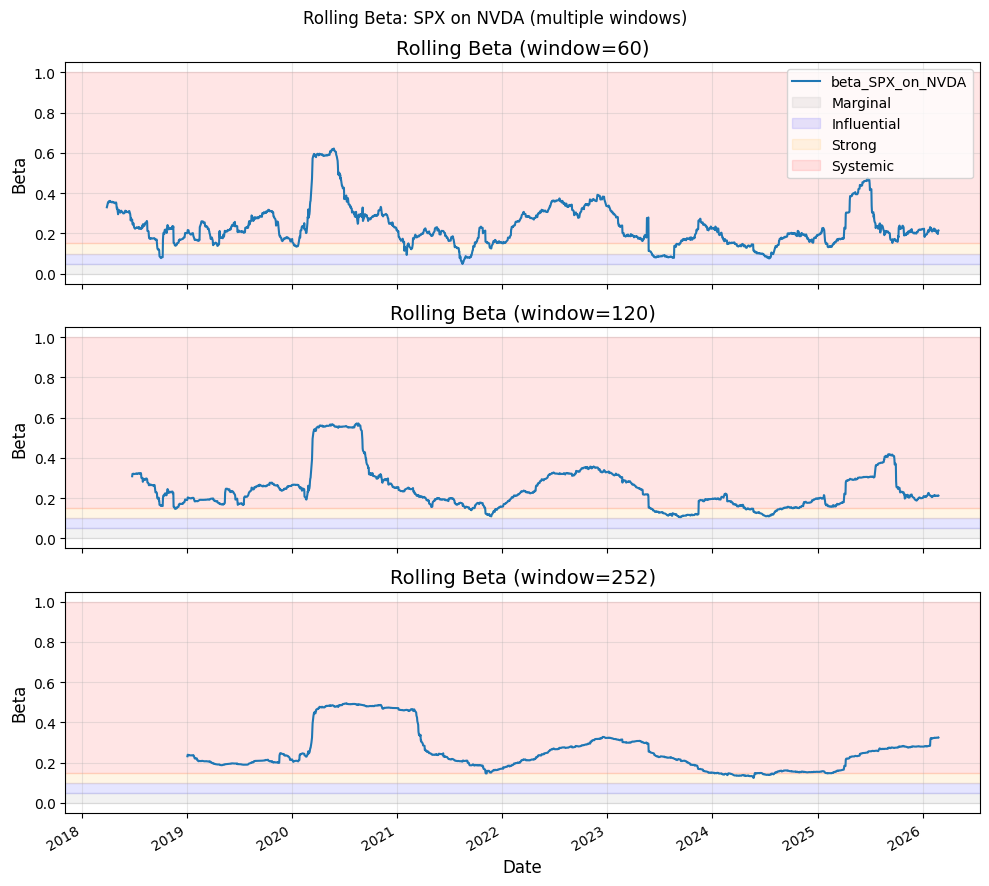

In [5]:
plot_rolling_beta_windows(
    rets["SPX"],
    rets["NVDA"],
    windows=[60, 120, 252],
    title="Rolling Beta: SPX on NVDA (multiple windows)",
);

**Caption.** Colored regions indicate heuristic beta regimes (marginal → influential → strong → systemic). Elevated beta reflects statistical co-movement rather than causal influence, but persistent elevation across window sizes suggests robust regime behavior.

### Interpretation of Results

Across window lengths, NVDA frequently exhibits elevated rolling beta values relative to SPX, with particularly pronounced peaks during early 2020 and again throughout 2025. While shorter windows capture sharper regime shifts, longer windows smooth transient fluctuations and highlight persistent relationships.

Importantly, elevated rolling beta reflects a strong statistical association, not necessarily causal influence. Beta measures co-movement conditional on variance structure within each window, and does not distinguish between directional influence and shared exposure to broader market factors. In fact, one may note from the formal equation for $\beta_t$ that elevated beta may arise either from increased covariance between NVDA and SPX or from reduced NVDA variance within the estimation window; the rolling framework does not disentangle these mechanisms.

Nevertheless, sustained periods of elevated beta suggest that NVDA’s return dynamics have been closely aligned with broader index movements during specific market regimes. The persistence of these regimes across multiple window lengths indicates that the observed relationship is not solely an artifact of short-horizon volatility.

## Shock Scenario Design

To evaluate stress sensitivity, stylized one-day shock scenarios were applied to NVDA returns within the linear decomposition framework.

On the selected shock date $t^*$, NVDA’s return is replaced with a specified shock magnitude $s$, and the implied SPX return is reconstructed as:

$$ r^{shock}_{SPX,t^*} = ws + (1-w)r_{ex,t^*}. $$

On all non-shock dates, NVDA is assumed neutral (zero return) in the counterfactual path, yielding:

$$ r^{shock}_{SPX,t^*} = (1-w)r_{ex,t}, \,\,\, t \neq t^*. $$

This design isolates the mechanical impact of a single-day NVDA shock under fixed structural exposure assumptions. The ex-NVDA return stream is held unchanged, and no endogenous feedback, volatility clustering, or secondary contagion effects are modeled.

In practice, large single-stock shocks may induce broader volatility adjustments or cross-asset spillovers. By holding the ex-NVDA component fixed, the present framework likely understates such dynamic effects and should therefore be interpreted accordingly as a lower-bound mechanical stress scenario rather than a fully dynamic market simulation.

In [6]:
w_demo = 0.07
shock_date = rets.index[-200]
shock_returns_demo = [-0.10, -0.30, -0.50]

ex_demo = ex_nvda_return(rets["SPX"], rets["NVDA"], w_demo)

shock_df_demo = shocked_spx_returns(
    ex_ret=ex_demo,
    weight=w_demo,
    shock_returns=shock_returns_demo,
    shock_date=shock_date,
)

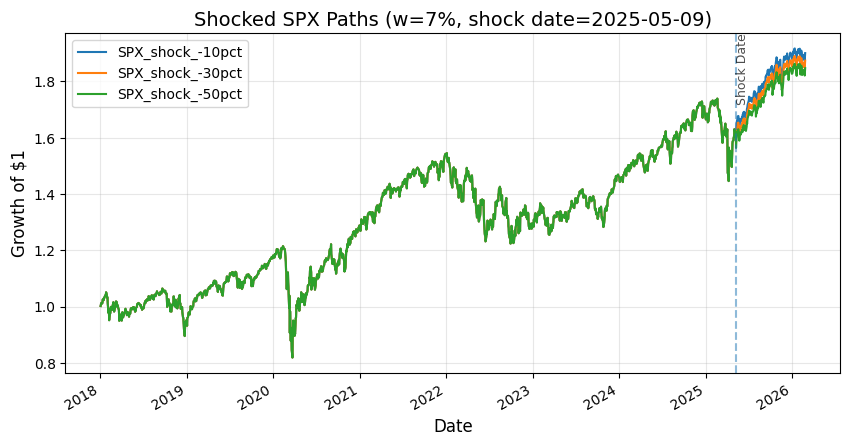

In [7]:
plot_cumulative(
    shock_df_demo,
    title=f"Shocked SPX Paths (w={w_demo:.0%}, shock date={shock_date.date()})",
    annotations={shock_date: "Shock Date"},
);

**Caption.** Under the stylized one-day shock framework, larger shock magnitudes mechanically deepen simulated drawdowns for fixed exposure $w$. This is intended as a lower-bound mechanical stress test (no feedback effects are modeled).

## Drawdown and Recovery Metrics

To quantify the severity of simulated stress scenarios, two metrics were computed:

1. **Maximum drawdown**, and
2. **Days to recovery**.

Cumulative growth paths were constructed from the simulated return series via:

$$ G_t = \prod_{u \leq t} (1 + r_u). $$

Let $G_{t^*-1}$ denote the cumulative level immediately prior to the shock date $t^*$. Drawdown is then measured relative to this pre-shock level.

### Maximum Drawdown

Maximum drawdown is defined as the largest percentage decline from the pre-shock level observed after the shock date:

$$ \mathrm{Max Drawdown} = \min_{t \geq t^*} \left( \frac{G_t - G_{t^*-1}}{G_{t^*-1}} \right). $$

This definition isolates the shock-induced decline rather than measuring against historical peaks unrelated to the stress event.

### Days to Recovery

Recovery time is defined as the number of trading days required for the cumulative growth path to return to or exceed the pre-shock level 
$G_{t^*-1}$. Formally, recovery occurs at the earliest $t > t^*$ such that:

$$ G_t > G_{t^*-1}. $$

These metrics provide complementary perspectives: maximum drawdown captures depth of stress, while days to recovery captures persistence.

## Sensitivity to NVDA Weight Assumptions

The parameter $w$ represents an assumed structural exposure of NVDA within SPX. Because this parameter is not directly estimated in the present framework, it is treated as uncertain and varied over a plausible range.

A grid of exposure weights (1%–10%) and one-day shock magnitudes was evaluated to assess how simulated stress outcomes depend on structural assumptions. For each combination, maximum drawdown and recovery time were computed relative to the pre-shock level.

In [8]:
weights = [0.01, 0.03, 0.05, 0.07, 0.10]
shock_returns = [-0.10, -0.30, -0.50, -0.70]

sens = weight_sensitivity_table(
    spx_ret=rets["SPX"],
    nvda_ret=rets["NVDA"],
    weights=weights,
    shock_returns=shock_returns,
    shock_date=shock_date,
)
sens

shock_date  pre_shock_level  max_drawdown_pct  \
weight scenario                                                         
0.01   SPX_shock_-10pct 2025-05-09         2.025734         -0.165014   
       SPX_shock_-30pct 2025-05-09         2.025734         -0.365014   
       SPX_shock_-50pct 2025-05-09         2.025734         -0.565014   
       SPX_shock_-70pct 2025-05-09         2.025734         -0.765014   
0.03   SPX_shock_-10pct 2025-05-09         1.882015         -0.352745   
       SPX_shock_-30pct 2025-05-09         1.882015         -0.952745   
       SPX_shock_-50pct 2025-05-09         1.882015         -1.552745   
       SPX_shock_-70pct 2025-05-09         1.882015         -2.152745   
0.05   SPX_shock_-10pct 2025-05-09         1.747065         -0.540475   
       SPX_shock_-30pct 2025-05-09         1.747065         -1.540475   
       SPX_shock_-50pct 2025-05-09         1.747065         -2.540475   
       SPX_shock_-70pct 2025-05-09         1.747065         -3.540475   
0.07   SPX_shock_-10pct 2025-05-09         1.620468         -0.728206   
       SPX_shock_-30pct 2025-05-09         1.620468         -2.128206   
       SPX_shock_-50pct 2025-05-09         1.620468         -3.528206   
       SPX_shock_-70pct 2025-05-09         1.620468         -4.928206   
0.10   SPX_shock_-10pct 2025-05-09         1.445350         -1.009803   
       SPX_shock_-30pct 2025-05-09         1.445350         -3.009803   
       SPX_shock_-50pct 2025-05-09         1.445350         -5.009803   
       SPX_shock_-70pct 2025-05-09         1.445350         -7.009803   

                        max_drawdown_date recovery_date  days_to_recovery  
weight scenario                                                            
0.01   SPX_shock_-10pct        2025-05-09    2025-05-12                 1  
       SPX_shock_-30pct        2025-05-09    2025-05-12                 1  
       SPX_shock_-50pct        2025-05-09    2025-05-12                 1  
       SPX_shock_-70pct        2025-05-09    2025-05-12                 1  
0.03   SPX_shock_-10pct        2025-05-09    2025-05-12                 1  
       SPX_shock_-30pct        2025-05-09    2025-05-12                 1  
       SPX_shock_-50pct        2025-05-09    2025-05-12                 1  
       SPX_shock_-70pct        2025-05-09    2025-05-12                 1  
0.05   SPX_shock_-10pct        2025-05-09    2025-05-12                 1  
       SPX_shock_-30pct        2025-05-09    2025-05-12                 1  
       SPX_shock_-50pct        2025-05-09    2025-05-12                 1  
       SPX_shock_-70pct        2025-05-09    2025-05-15                 4  
0.07   SPX_shock_-10pct        2025-05-09    2025-05-12                 1  
       SPX_shock_-30pct        2025-05-09    2025-05-12                 1  
       SPX_shock_-50pct        2025-05-09    2025-05-16                 5  
       SPX_shock_-70pct        2025-05-09    2025-06-24                30  
0.10   SPX_shock_-10pct        2025-05-09    2025-05-12                 1  
       SPX_shock_-30pct        2025-05-09    2025-05-16                 5  
       SPX_shock_-50pct        2025-05-09    2025-06-26                32  
       SPX_shock_-70pct        2025-05-09    2025-07-23                50

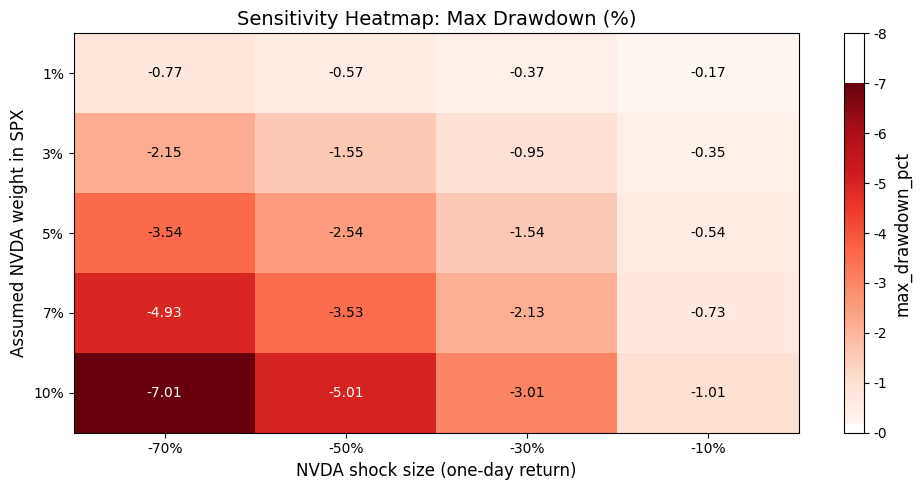

In [9]:
plot_sensitivity_heatmap(
    sens,
    metric="max_drawdown_pct",
    title="Sensitivity Heatmap: Max Drawdown (%)",
    annotate=True,
);

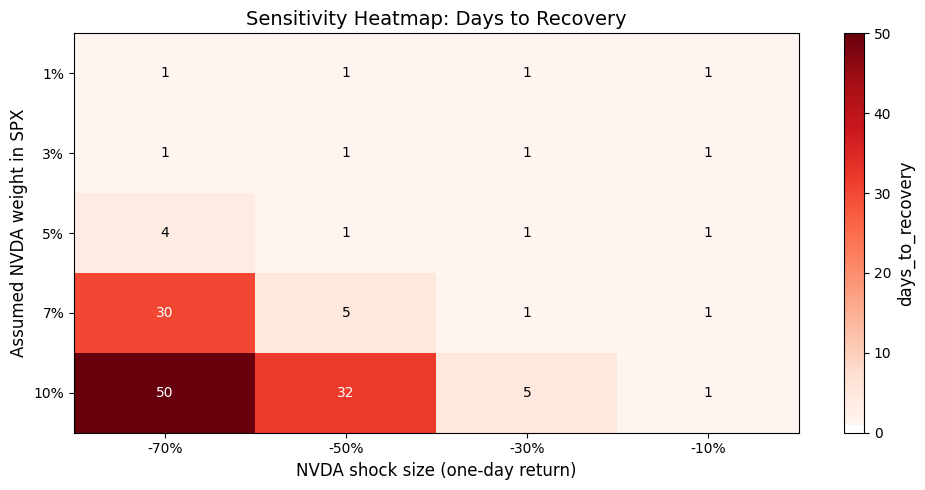

In [10]:
plot_sensitivity_heatmap(
    sens,
    metric="days_to_recovery",
    title="Sensitivity Heatmap: Days to Recovery",
    annotate=True,
);

**Caption.** Darker cells indicate worse outcomes under the chosen metric. Stress severity is highly sensitive to the assumed structural exposure weight $w$, consistent with the decomposition framework.

### Structural Interpretation

The sensitivity heatmaps demonstrate that simulated index drawdowns are materially dependent on the assumed exposure weight. Larger values of $w$ amplify the mechanical transmission of NVDA shocks into SPX returns, producing deeper simulated drawdowns under otherwise identical conditions.

While the scaling of drawdown severity with both shock magnitude and exposure weight is mechanically consistent with the linear decomposition framework, the broader implication is structural: stress conclusions are highly sensitive to assumptions regarding dominant constituent exposure.

In contrast, recovery times remain short in most simulated cases within the observed sample, except under extreme combinations of large weights and severe shocks. This asymmetry suggests that, under the stylized one-day framework, depth of stress is more sensitive to exposure assumptions than persistence of stress.

### Interpretation Caveat

These findings reflect mechanical exposure sensitivity rather than dynamic contagion modeling. Because the ex-NVDA component is held fixed and volatility feedback is excluded, the heatmaps should be interpreted as exposure stress maps under simplified assumptions rather than as realistic forecasts of index behavior.

## Limitations and Extensions

This analysis is intentionally stylized and subject to several important limitations.

### 1. Constant Exposure Assumption

The parameter $w$ is treated as constant within each scenario. In practice, index weights evolve over time with changes in market capitalization and index rebalancing. A more realistic implementation would incorporate time-varying weights derived from historical constituent market caps.

### 2. Linear Decomposition Framework

The decomposition assumes a linear relationship between SPX and NVDA returns. While mechanically convenient, real-world index dynamics may exhibit nonlinear effects, regime shifts, or structural breaks that are not captured in this framework.

### 3. Single-Day Shock Design

Shocks are modeled as one-day impulses. Real-world stress events often unfold over multiple days, with volatility clustering and path dependence. Extending the framework to multi-day shock paths or decay functions would provide a more realistic stress simulation.

### 4. No Endogenous Feedback or Contagion

The ex-NVDA return stream is held fixed under shock scenarios. In practice, large single-stock shocks may induce broader volatility repricing, liquidity effects, or cross-asset contagion. By excluding such dynamics, the model likely understates the full systemic impact of extreme events.

### 5. Absence of Volatility Modeling

The framework focuses on return levels rather than volatility dynamics. Incorporating stochastic volatility or regime-switching behavior could materially alter stress persistence characteristics.

### Potential Extensions

Several natural extensions follow from these limitations:

* Estimating time-varying exposure weights from historical market capitalization data.
* Introducing multi-day or decaying shock paths.
* Modeling volatility clustering or conditional heteroskedasticity.
* Comparing results using alternative SPX proxies (e.g., ETF-based series).
* Extending the framework to other dominant constituents for comparative analysis.

## Conclusion

This study evaluated the structural sensitivity of S&P 500 drawdown behavior to assumed NVDA exposure within a simplified linear decomposition framework.

Rolling beta analysis indicates that NVDA has exhibited sustained periods of elevated statistical association with SPX returns, particularly during early 2020 and again in 2025. While beta measures co-movement rather than causality, the persistence of elevated regimes across multiple window lengths suggests that NVDA has functioned as a materially influential constituent during specific market phases.

Shock simulations demonstrate that index-level drawdowns scale mechanically with both shock magnitude and assumed exposure weight. Sensitivity analysis further highlights that stress outcomes are materially dependent on structural exposure assumptions: even under a stylized framework, larger assumed NVDA weights meaningfully amplify simulated drawdowns.

At the same time, the framework is intentionally simplified. It excludes endogenous volatility feedback, nonlinear dynamics, and time-varying exposure effects. As such, the results should be interpreted as structural stress sensitivity analysis rather than predictive modeling.

Future work could extend this framework to incorporate dynamic exposure estimation, multi-day shock paths, and volatility modeling. More broadly, the methodology may be applied to other dominant index constituents to evaluate concentration risk under alternative structural assumptions.